Adaptive Distances
==================

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('DistanceFunction')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1*scipy.randn(),
            'ss2': 2 + 10*scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as1.db")
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:Epsilon:initial epsilon is 7.458325655104816
INFO:History:Start <ABCSMC(id=2, start_time=2018-04-13 15:16:58.749453, end_time=None)>
INFO:ABC:t:0 eps:7.458325655104816
INFO:ABC:t:1 eps:4.687149115789578
INFO:ABC:t:2 eps:3.1277819201795505
INFO:ABC:t:3 eps:2.132930244054853
INFO:ABC:t:4 eps:1.6516604991557626
INFO:ABC:t:5 eps:1.212351379498632
INFO:ABC:t:6 eps:0.8281241711554506
INFO:ABC:t:7 eps:0.5915454422183215
INFO:History:Done <ABCSMC(id=2, start_time=2018-04-13 15:16:58.749453, end_time=2018-04-13 15:17:39.996034)>


Let us visualize the results for the non-adaptive distance:

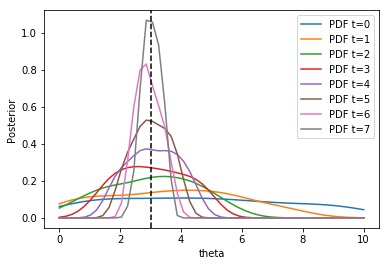

In [3]:
fig, ax = pyplot.subplots()
for t in range(history1.max_t + 1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

Second, we consider an adaptive Euclidean distance:

In [4]:
distance = pyabc.AdaptivePNormDistance(p=2, adaptive=True)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as2.db")
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

DEBUG:DistanceFunction:update distance weights = {'ss1': 1.4662255488444025, 'ss2': 0.53377445115559752}
INFO:Epsilon:initial epsilon is 6.839758348571029
INFO:History:Start <ABCSMC(id=2, start_time=2018-04-13 15:17:54.556918, end_time=None)>
INFO:ABC:t:0 eps:6.839758348571029
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.3930763819907674, 'ss2': 0.60692361800923256}
INFO:ABC:t:1 eps:4.280644638005028
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.6008901638879982, 'ss2': 0.39910983611200168}
INFO:ABC:t:2 eps:2.5152890084494977
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.6794631786710088, 'ss2': 0.32053682132899114}
INFO:ABC:t:3 eps:1.569497893508946
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.8498456066518569, 'ss2': 0.15015439334814312}
INFO:ABC:t:4 eps:0.8607426368437837
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.877746533868391, 'ss2': 0.12225346613160899}
INFO:ABC:t:5 eps:0.5615813162778728
DEBUG:DistanceFuncti

In the debug output of abc.run above, it can be seen how the weights evolve over time. Let us visualize the results for the adaptive distance:

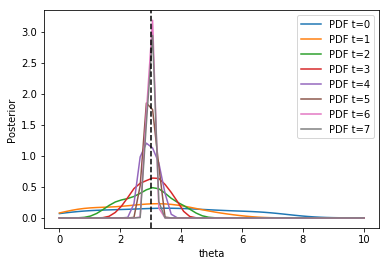

In [5]:
fig, ax = pyplot.subplots()
for t in range(history2.max_t + 1):
    df, w = history2.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$.

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practise, please inspect the code of ``AdaptivePNormDistance``.